We first train a universal model and plot the confusion matrix to show that it would not be feasible to have just one classifier. We then train one-vs-all classifiers and compare their accuracies.

In [1]:
import sys
sys.path.append('..')

import random
from sklearn import metrics
import seaborn as sns

In [2]:
from utils.constants import *
from utils.file_readers import *
from utils.data_exploration import *
from utils.signal_processing import *
from utils.sliding_window import *

In [3]:
df_all_normalised = pd.read_csv('../Preprocessed/all_data.csv')

Generate sets for training, validation and test. With 15 subjects, we should have:

- 12 for training
- 2 for validation
- 1 for test

In [26]:
subjects = get_subject_names()

n_training = 12
n_validation = 2
n_test = 1

In [27]:
shuffled = [subjects[i] for i in random.sample(range(len(subjects)), len(subjects))]
train_subjects = shuffled[:n_training]
valid_subjects = shuffled[n_training:n_training+n_validation]
test_subjects = shuffled[-n_test:]

## One classifier for all

Import tensorflow stuff

In [3]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Conv1D, Dropout, MaxPooling1D, BatchNormalization
from keras import optimizers

Using TensorFlow backend.


Generate datasets

In [29]:
n_time_steps = 38
step = 19
n_features = 3

In [30]:
X_train, y_train = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=['accel_x', 'accel_y', 'accel_z'],
                                   one_vs_all_activity='all', subjects=train_subjects, correctness='correct')

Total samples for true activity = 1870
Total samples for false activity = 0


In [31]:
X_valid, y_valid = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=['accel_x', 'accel_y', 'accel_z'],
                                   one_vs_all_activity='all', subjects=valid_subjects, correctness='correct')

Total samples for true activity = 249
Total samples for false activity = 0


In [32]:
X_test, y_test = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=['accel_x', 'accel_y', 'accel_z'],
                                   one_vs_all_activity='all', subjects=test_subjects, correctness='correct')

Total samples for true activity = 201
Total samples for false activity = 0


Build network

In [33]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 10

model = Sequential()
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation, input_shape=(n_time_steps, n_features)))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model.add(BatchNormalization())
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 36, 64)            640       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_3 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 64)            12352     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 36, 64)            640       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

NoneType

In [34]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

In [35]:
model.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy', 'mse'])

In [36]:
batch_size = 32
epochs = 200

history = model.fit(X_train, y_train,
                   batch_size=batch_size, epochs=epochs,
                   validation_data=(X_valid, y_valid))

Train on 1870 samples, validate on 249 samples
Epoch 1/200
1870/1870 [==============================] - 4s 2ms/step - loss: 2.4091 - accuracy: 0.1150 - mse: 0.0924 - val_loss: 2.3034 - val_accuracy: 0.1365 - val_mse: 0.0900
Epoch 2/200
1870/1870 [==============================] - 1s 721us/step - loss: 2.3551 - accuracy: 0.1021 - mse: 0.0912 - val_loss: 2.2973 - val_accuracy: 0.1767 - val_mse: 0.0899
Epoch 3/200
1870/1870 [==============================] - 2s 833us/step - loss: 2.3205 - accuracy: 0.0984 - mse: 0.0905 - val_loss: 2.2907 - val_accuracy: 0.1647 - val_mse: 0.0897
Epoch 4/200
1870/1870 [==============================] - 1s 730us/step - loss: 2.2921 - accuracy: 0.1075 - mse: 0.0899 - val_loss: 2.2837 - val_accuracy: 0.1647 - val_mse: 0.0896
Epoch 5/200
1870/1870 [==============================] - 1s 721us/step - loss: 2.2698 - accuracy: 0.1294 - mse: 0.0894 - val_loss: 2.2754 - val_accuracy: 0.1647 - val_mse: 0.0894
Epoch 6/200
1870/1870 [==============================] - 1s 

1870/1870 [==============================] - 1s 762us/step - loss: 1.7900 - accuracy: 0.3604 - mse: 0.0756 - val_loss: 1.8205 - val_accuracy: 0.4096 - val_mse: 0.0767
Epoch 92/200
1870/1870 [==============================] - 2s 818us/step - loss: 1.7880 - accuracy: 0.3615 - mse: 0.0756 - val_loss: 1.8171 - val_accuracy: 0.4137 - val_mse: 0.0766
Epoch 93/200
1870/1870 [==============================] - 1s 734us/step - loss: 1.7856 - accuracy: 0.3642 - mse: 0.0755 - val_loss: 1.8170 - val_accuracy: 0.4137 - val_mse: 0.0766
Epoch 94/200
1870/1870 [==============================] - 1s 748us/step - loss: 1.7841 - accuracy: 0.3626 - mse: 0.0754 - val_loss: 1.8148 - val_accuracy: 0.4177 - val_mse: 0.0766
Epoch 95/200
1870/1870 [==============================] - 1s 766us/step - loss: 1.7805 - accuracy: 0.3668 - mse: 0.0753 - val_loss: 1.8116 - val_accuracy: 0.4177 - val_mse: 0.0765
Epoch 96/200
1870/1870 [==============================] - 1s 745us/step - loss: 1.7784 - accuracy: 0.3674 - mse: 

1870/1870 [==============================] - 1s 744us/step - loss: 1.5866 - accuracy: 0.4481 - mse: 0.0693 - val_loss: 1.6127 - val_accuracy: 0.4819 - val_mse: 0.0699
Epoch 182/200
1870/1870 [==============================] - 1s 724us/step - loss: 1.5841 - accuracy: 0.4460 - mse: 0.0692 - val_loss: 1.6114 - val_accuracy: 0.4819 - val_mse: 0.0698
Epoch 183/200
1870/1870 [==============================] - 1s 725us/step - loss: 1.5833 - accuracy: 0.4406 - mse: 0.0692 - val_loss: 1.6093 - val_accuracy: 0.4819 - val_mse: 0.0698
Epoch 184/200
1870/1870 [==============================] - 1s 723us/step - loss: 1.5794 - accuracy: 0.4503 - mse: 0.0691 - val_loss: 1.6072 - val_accuracy: 0.4819 - val_mse: 0.0697
Epoch 185/200
1870/1870 [==============================] - 1s 728us/step - loss: 1.5765 - accuracy: 0.4444 - mse: 0.0690 - val_loss: 1.6032 - val_accuracy: 0.4900 - val_mse: 0.0696
Epoch 186/200
1870/1870 [==============================] - 1s 724us/step - loss: 1.5739 - accuracy: 0.4508 - 

In [37]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [38]:
activity_labels = get_activity_label_dict()
cm_labels = [activity_labels[i] for i in range(10)]

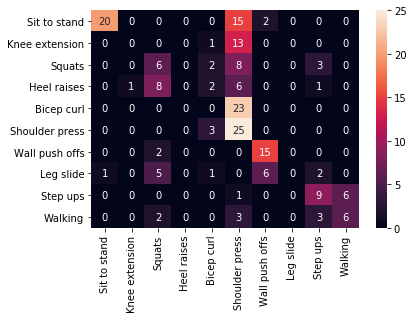

In [39]:
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')

In [42]:
final_loss, final_acc, final_mse = model.evaluate(X_test, y_test, batch_size)
print("Final loss = {}".format(final_loss))
print("Final accuracy = {}".format(final_acc))

201/201 [==============================] - 0s 350us/step
Final loss = 1.9183077242837023
Final accuracy = 0.4029850661754608


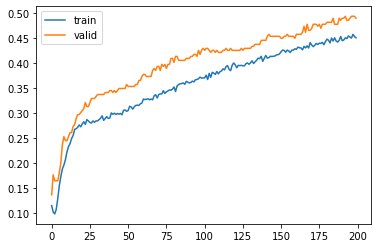

In [47]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()

Training strategy:

- first try to max out the number of epochs, until you see no more improvement in either training or validation
- then start to vary the batch size
- then tweak the architecture

Need to record all the training stats, the validation and test accuracies, the confusion matrices and the learning curves. 

In [48]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 10

model = Sequential()
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation, input_shape=(n_time_steps, n_features)))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model.add(BatchNormalization())
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 36, 64)            640       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [49]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

# compile model
model.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy', 'mse'])

# train model
batch_size = 32
epochs = 500

history = model.fit(X_train, y_train,
                   batch_size=batch_size, epochs=epochs,
                   validation_data=(X_valid, y_valid))

Train on 1870 samples, validate on 249 samples
Epoch 1/500
1870/1870 [==============================] - 3s 2ms/step - loss: 2.3929 - accuracy: 0.1166 - mse: 0.0922 - val_loss: 2.2893 - val_accuracy: 0.1205 - val_mse: 0.0897
Epoch 2/500
1870/1870 [==============================] - 1s 727us/step - loss: 2.3190 - accuracy: 0.1278 - mse: 0.0906 - val_loss: 2.2813 - val_accuracy: 0.1325 - val_mse: 0.0896
Epoch 3/500
1870/1870 [==============================] - 1s 731us/step - loss: 2.2802 - accuracy: 0.1545 - mse: 0.0898 - val_loss: 2.2710 - val_accuracy: 0.2410 - val_mse: 0.0894
Epoch 4/500
1870/1870 [==============================] - 1s 732us/step - loss: 2.2514 - accuracy: 0.1658 - mse: 0.0891 - val_loss: 2.2583 - val_accuracy: 0.2410 - val_mse: 0.0891
Epoch 5/500
1870/1870 [==============================] - 2s 840us/step - loss: 2.2290 - accuracy: 0.1850 - mse: 0.0886 - val_loss: 2.2425 - val_accuracy: 0.2530 - val_mse: 0.0888
Epoch 6/500
1870/1870 [==============================] - 1s 

1870/1870 [==============================] - 2s 925us/step - loss: 1.6509 - accuracy: 0.4160 - mse: 0.0716 - val_loss: 1.5659 - val_accuracy: 0.4980 - val_mse: 0.0694
Epoch 92/500
1870/1870 [==============================] - 2s 836us/step - loss: 1.6490 - accuracy: 0.4171 - mse: 0.0716 - val_loss: 1.5593 - val_accuracy: 0.5020 - val_mse: 0.0692
Epoch 93/500
1870/1870 [==============================] - 1s 791us/step - loss: 1.6437 - accuracy: 0.4144 - mse: 0.0714 - val_loss: 1.5554 - val_accuracy: 0.4980 - val_mse: 0.0691
Epoch 94/500
1870/1870 [==============================] - 2s 875us/step - loss: 1.6414 - accuracy: 0.4198 - mse: 0.0714 - val_loss: 1.5543 - val_accuracy: 0.4940 - val_mse: 0.0690
Epoch 95/500
1870/1870 [==============================] - 2s 807us/step - loss: 1.6372 - accuracy: 0.4198 - mse: 0.0713 - val_loss: 1.5532 - val_accuracy: 0.4940 - val_mse: 0.0690
Epoch 96/500
1870/1870 [==============================] - 1s 736us/step - loss: 1.6326 - accuracy: 0.4225 - mse: 

1870/1870 [==============================] - 2s 816us/step - loss: 1.3555 - accuracy: 0.5139 - mse: 0.0623 - val_loss: 1.3293 - val_accuracy: 0.5261 - val_mse: 0.0629
Epoch 182/500
1870/1870 [==============================] - 2s 813us/step - loss: 1.3508 - accuracy: 0.5166 - mse: 0.0621 - val_loss: 1.3109 - val_accuracy: 0.5462 - val_mse: 0.0621
Epoch 183/500
1870/1870 [==============================] - 1s 705us/step - loss: 1.3469 - accuracy: 0.5155 - mse: 0.0620 - val_loss: 1.3082 - val_accuracy: 0.5462 - val_mse: 0.0620
Epoch 184/500
1870/1870 [==============================] - 2s 890us/step - loss: 1.3482 - accuracy: 0.5176 - mse: 0.0621 - val_loss: 1.3086 - val_accuracy: 0.5422 - val_mse: 0.0621
Epoch 185/500
1870/1870 [==============================] - 1s 789us/step - loss: 1.3493 - accuracy: 0.5214 - mse: 0.0622 - val_loss: 1.3172 - val_accuracy: 0.5341 - val_mse: 0.0625
Epoch 186/500
1870/1870 [==============================] - 1s 764us/step - loss: 1.3428 - accuracy: 0.5171 - 

1870/1870 [==============================] - 1s 710us/step - loss: 1.2496 - accuracy: 0.5529 - mse: 0.0587 - val_loss: 1.2462 - val_accuracy: 0.5462 - val_mse: 0.0605
Epoch 227/500
1870/1870 [==============================] - 1s 714us/step - loss: 1.2424 - accuracy: 0.5567 - mse: 0.0583 - val_loss: 1.2385 - val_accuracy: 0.5582 - val_mse: 0.0602
Epoch 228/500
1870/1870 [==============================] - 2s 908us/step - loss: 1.2436 - accuracy: 0.5556 - mse: 0.0584 - val_loss: 1.2604 - val_accuracy: 0.5341 - val_mse: 0.0612
Epoch 229/500
1870/1870 [==============================] - 2s 809us/step - loss: 1.2381 - accuracy: 0.5540 - mse: 0.0582 - val_loss: 1.2386 - val_accuracy: 0.5502 - val_mse: 0.0602
Epoch 230/500
1870/1870 [==============================] - 2s 836us/step - loss: 1.2380 - accuracy: 0.5626 - mse: 0.0583 - val_loss: 1.2469 - val_accuracy: 0.5502 - val_mse: 0.0607
Epoch 231/500
1870/1870 [==============================] - 2s 834us/step - loss: 1.2340 - accuracy: 0.5658 - 

1870/1870 [==============================] - 2s 1ms/step - loss: 1.0916 - accuracy: 0.6150 - mse: 0.0528 - val_loss: 1.1375 - val_accuracy: 0.5783 - val_mse: 0.0569
Epoch 317/500
1870/1870 [==============================] - 2s 923us/step - loss: 1.0847 - accuracy: 0.6187 - mse: 0.0525 - val_loss: 1.1467 - val_accuracy: 0.5622 - val_mse: 0.0576
Epoch 318/500
1870/1870 [==============================] - 2s 830us/step - loss: 1.0852 - accuracy: 0.6176 - mse: 0.0525 - val_loss: 1.1405 - val_accuracy: 0.5743 - val_mse: 0.0572
Epoch 319/500
1870/1870 [==============================] - 1s 758us/step - loss: 1.0817 - accuracy: 0.6187 - mse: 0.0524 - val_loss: 1.1490 - val_accuracy: 0.5622 - val_mse: 0.0577
Epoch 320/500
1870/1870 [==============================] - 2s 891us/step - loss: 1.0766 - accuracy: 0.6273 - mse: 0.0522 - val_loss: 1.1410 - val_accuracy: 0.5703 - val_mse: 0.0573
Epoch 321/500
1870/1870 [==============================] - 2s 883us/step - loss: 1.0764 - accuracy: 0.6219 - ms

1870/1870 [==============================] - 2s 916us/step - loss: 0.9713 - accuracy: 0.6791 - mse: 0.0478 - val_loss: 1.0961 - val_accuracy: 0.5542 - val_mse: 0.0560
Epoch 407/500
1870/1870 [==============================] - 2s 910us/step - loss: 0.9675 - accuracy: 0.6733 - mse: 0.0477 - val_loss: 1.1208 - val_accuracy: 0.5341 - val_mse: 0.0574
Epoch 408/500
1870/1870 [==============================] - 2s 832us/step - loss: 0.9692 - accuracy: 0.6701 - mse: 0.0479 - val_loss: 1.1476 - val_accuracy: 0.5181 - val_mse: 0.0586
Epoch 409/500
1870/1870 [==============================] - 1s 790us/step - loss: 0.9736 - accuracy: 0.6610 - mse: 0.0480 - val_loss: 1.1006 - val_accuracy: 0.5462 - val_mse: 0.0563
Epoch 410/500
1870/1870 [==============================] - 2s 813us/step - loss: 0.9659 - accuracy: 0.6722 - mse: 0.0476 - val_loss: 1.1101 - val_accuracy: 0.5341 - val_mse: 0.0569
Epoch 411/500
1870/1870 [==============================] - 2s 804us/step - loss: 0.9683 - accuracy: 0.6770 - 

1870/1870 [==============================] - 1s 709us/step - loss: 0.8821 - accuracy: 0.7182 - mse: 0.0440 - val_loss: 1.0737 - val_accuracy: 0.5542 - val_mse: 0.0556
Epoch 497/500
1870/1870 [==============================] - 1s 734us/step - loss: 0.8870 - accuracy: 0.6989 - mse: 0.0443 - val_loss: 1.0595 - val_accuracy: 0.5462 - val_mse: 0.0547
Epoch 498/500
1870/1870 [==============================] - 1s 760us/step - loss: 0.8821 - accuracy: 0.7107 - mse: 0.0439 - val_loss: 1.0632 - val_accuracy: 0.5422 - val_mse: 0.0550
Epoch 499/500
1870/1870 [==============================] - 1s 782us/step - loss: 0.8816 - accuracy: 0.7048 - mse: 0.0437 - val_loss: 1.1205 - val_accuracy: 0.5181 - val_mse: 0.0580
Epoch 500/500
1870/1870 [==============================] - 1s 770us/step - loss: 0.8811 - accuracy: 0.7070 - mse: 0.0438 - val_loss: 1.0969 - val_accuracy: 0.5382 - val_mse: 0.0569


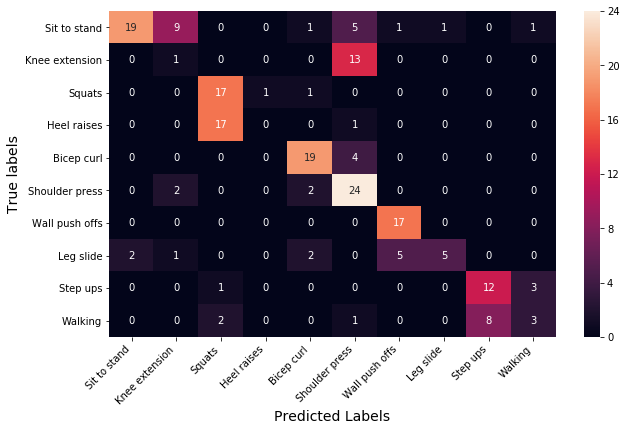

In [61]:
# plot cm
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

activity_labels = get_activity_label_dict()
cm_labels = [activity_labels[i] for i in range(10)]

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
plt.xlabel("Predicted Labels", fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.ylabel("True labels", fontsize=14)

plt.savefig("../Plots/05_Universal_classifier/baseline_model_cm.pdf")

In [51]:
final_loss, final_acc, final_mse = model.evaluate(X_test, y_test, batch_size)
print("Final loss = {}".format(final_loss))
print("Final accuracy = {}".format(final_acc))

201/201 [==============================] - 0s 562us/step
Final loss = 1.411087587105101
Final accuracy = 0.5820895433425903


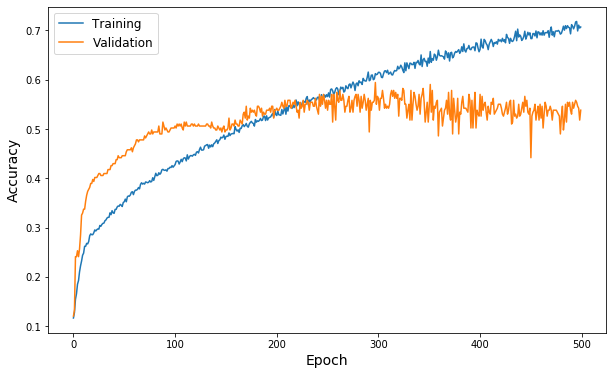

In [70]:
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.savefig("../Plots/05_Universal_classifier/baseline_model_learning_curve.pdf")

So it's pretty clear that after around 200 epochs the validation accuracy becomes very varied but stabilises at around 0.55. 

We will only train until epoch = 300 for further experiments.

### Next point - does the normalised data help?

In [71]:
n_time_steps = 38
step = 19
n_features = 3
features = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']

X_train, y_train = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=train_subjects, correctness='correct')

X_valid, y_valid = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=valid_subjects, correctness='correct')

X_test, y_test = generate_dataset(df=df_all_normalised, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity='all', subjects=test_subjects, correctness='correct')

Total samples for true activity = 1870
Total samples for false activity = 0
Total samples for true activity = 249
Total samples for false activity = 0
Total samples for true activity = 201
Total samples for false activity = 0


Again, we build the network with the default parameters, compile and train for 500 epochs so we can see clearly how the baseline compares to this.

In [72]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 10

model_norm = Sequential()
model_norm.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation, input_shape=(n_time_steps, n_features)))
model_norm.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model_norm.add(BatchNormalization())
model_norm.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                 activation=activation))
model_norm.add(Flatten())
model_norm.add(Dense(100, activation='relu'))
model_norm.add(Dense(n_classes, activation='softmax'))

model_norm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 36, 64)            640       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [73]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

# compile model
model_norm.compile(optimizer=sgd,
             loss='categorical_crossentropy',
             metrics=['accuracy', 'mse'])

# train model
batch_size = 32
epochs = 500

history_norm = model_norm.fit(X_train, y_train,
                   batch_size=batch_size, epochs=epochs,
                   validation_data=(X_valid, y_valid))

Train on 1870 samples, validate on 249 samples
Epoch 1/500
1870/1870 [==============================] - 4s 2ms/step - loss: 2.4170 - accuracy: 0.0604 - mse: 0.0926 - val_loss: 2.3063 - val_accuracy: 0.0562 - val_mse: 0.0901
Epoch 2/500
1870/1870 [==============================] - 1s 732us/step - loss: 2.3822 - accuracy: 0.0615 - mse: 0.0919 - val_loss: 2.3050 - val_accuracy: 0.0723 - val_mse: 0.0901
Epoch 3/500
1870/1870 [==============================] - 1s 729us/step - loss: 2.3507 - accuracy: 0.0743 - mse: 0.0912 - val_loss: 2.3027 - val_accuracy: 0.0763 - val_mse: 0.0900
Epoch 4/500
1870/1870 [==============================] - 1s 779us/step - loss: 2.3220 - accuracy: 0.0984 - mse: 0.0905 - val_loss: 2.2992 - val_accuracy: 0.0884 - val_mse: 0.0899
Epoch 5/500
1870/1870 [==============================] - 1s 757us/step - loss: 2.2967 - accuracy: 0.1251 - mse: 0.0899 - val_loss: 2.2939 - val_accuracy: 0.1165 - val_mse: 0.0898
Epoch 6/500
1870/1870 [==============================] - 1s 

1870/1870 [==============================] - 1s 737us/step - loss: 1.3933 - accuracy: 0.6273 - mse: 0.0604 - val_loss: 1.3743 - val_accuracy: 0.6185 - val_mse: 0.0601
Epoch 92/500
1870/1870 [==============================] - 1s 736us/step - loss: 1.3842 - accuracy: 0.6321 - mse: 0.0600 - val_loss: 1.3643 - val_accuracy: 0.6225 - val_mse: 0.0597
Epoch 93/500
1870/1870 [==============================] - 1s 713us/step - loss: 1.3735 - accuracy: 0.6369 - mse: 0.0596 - val_loss: 1.3541 - val_accuracy: 0.6225 - val_mse: 0.0593
Epoch 94/500
1870/1870 [==============================] - 1s 732us/step - loss: 1.3673 - accuracy: 0.6342 - mse: 0.0594 - val_loss: 1.3437 - val_accuracy: 0.6345 - val_mse: 0.0589
Epoch 95/500
1870/1870 [==============================] - 1s 735us/step - loss: 1.3574 - accuracy: 0.6358 - mse: 0.0590 - val_loss: 1.3335 - val_accuracy: 0.6386 - val_mse: 0.0585
Epoch 96/500
1870/1870 [==============================] - 1s 725us/step - loss: 1.3488 - accuracy: 0.6449 - mse: 

1870/1870 [==============================] - 1s 725us/step - loss: 0.7816 - accuracy: 0.8230 - mse: 0.0346 - val_loss: 0.7226 - val_accuracy: 0.8514 - val_mse: 0.0326
Epoch 182/500
1870/1870 [==============================] - 1s 721us/step - loss: 0.7765 - accuracy: 0.8267 - mse: 0.0345 - val_loss: 0.7179 - val_accuracy: 0.8554 - val_mse: 0.0324
Epoch 183/500
1870/1870 [==============================] - 1s 774us/step - loss: 0.7793 - accuracy: 0.8225 - mse: 0.0347 - val_loss: 0.7129 - val_accuracy: 0.8554 - val_mse: 0.0322
Epoch 184/500
1870/1870 [==============================] - 2s 838us/step - loss: 0.7739 - accuracy: 0.8273 - mse: 0.0343 - val_loss: 0.7092 - val_accuracy: 0.8554 - val_mse: 0.0320
Epoch 185/500
1870/1870 [==============================] - 1s 756us/step - loss: 0.7643 - accuracy: 0.8262 - mse: 0.0339 - val_loss: 0.7054 - val_accuracy: 0.8554 - val_mse: 0.0318
Epoch 186/500
1870/1870 [==============================] - 1s 759us/step - loss: 0.7653 - accuracy: 0.8289 - 

1870/1870 [==============================] - 1s 714us/step - loss: 0.5443 - accuracy: 0.8679 - mse: 0.0241 - val_loss: 0.4933 - val_accuracy: 0.8876 - val_mse: 0.0219
Epoch 272/500
1870/1870 [==============================] - 1s 704us/step - loss: 0.5443 - accuracy: 0.8738 - mse: 0.0240 - val_loss: 0.4919 - val_accuracy: 0.8876 - val_mse: 0.0218
Epoch 273/500
1870/1870 [==============================] - 1s 703us/step - loss: 0.5402 - accuracy: 0.8690 - mse: 0.0239 - val_loss: 0.4906 - val_accuracy: 0.8876 - val_mse: 0.0218
Epoch 274/500
1870/1870 [==============================] - 1s 753us/step - loss: 0.5387 - accuracy: 0.8668 - mse: 0.0239 - val_loss: 0.4896 - val_accuracy: 0.8876 - val_mse: 0.0217
Epoch 275/500
1870/1870 [==============================] - 1s 755us/step - loss: 0.5352 - accuracy: 0.8701 - mse: 0.0237 - val_loss: 0.4881 - val_accuracy: 0.8876 - val_mse: 0.0217
Epoch 276/500
1870/1870 [==============================] - 2s 829us/step - loss: 0.5331 - accuracy: 0.8679 - 

1870/1870 [==============================] - 2s 828us/step - loss: 0.4301 - accuracy: 0.8930 - mse: 0.0193 - val_loss: 0.3994 - val_accuracy: 0.9157 - val_mse: 0.0174
Epoch 362/500
1870/1870 [==============================] - 1s 779us/step - loss: 0.4279 - accuracy: 0.8898 - mse: 0.0191 - val_loss: 0.3989 - val_accuracy: 0.9157 - val_mse: 0.0174
Epoch 363/500
1870/1870 [==============================] - 2s 857us/step - loss: 0.4226 - accuracy: 0.8968 - mse: 0.0188 - val_loss: 0.3978 - val_accuracy: 0.9157 - val_mse: 0.0174
Epoch 364/500
1870/1870 [==============================] - 1s 800us/step - loss: 0.4290 - accuracy: 0.8904 - mse: 0.0194 - val_loss: 0.3971 - val_accuracy: 0.9157 - val_mse: 0.0173
Epoch 365/500
1870/1870 [==============================] - 2s 812us/step - loss: 0.4283 - accuracy: 0.8914 - mse: 0.0192 - val_loss: 0.3964 - val_accuracy: 0.9116 - val_mse: 0.0173
Epoch 366/500
1870/1870 [==============================] - 2s 930us/step - loss: 0.4201 - accuracy: 0.9000 - 

1870/1870 [==============================] - 2s 985us/step - loss: 0.3486 - accuracy: 0.9091 - mse: 0.0156 - val_loss: 0.3511 - val_accuracy: 0.9116 - val_mse: 0.0151
Epoch 452/500
1870/1870 [==============================] - 1s 784us/step - loss: 0.3556 - accuracy: 0.9091 - mse: 0.0160 - val_loss: 0.3506 - val_accuracy: 0.9116 - val_mse: 0.0151
Epoch 453/500
1870/1870 [==============================] - 1s 755us/step - loss: 0.3534 - accuracy: 0.9086 - mse: 0.0159 - val_loss: 0.3504 - val_accuracy: 0.9116 - val_mse: 0.0151
Epoch 454/500
1870/1870 [==============================] - 1s 747us/step - loss: 0.3534 - accuracy: 0.9107 - mse: 0.0158 - val_loss: 0.3500 - val_accuracy: 0.9116 - val_mse: 0.0151
Epoch 455/500
1870/1870 [==============================] - 1s 742us/step - loss: 0.3494 - accuracy: 0.9118 - mse: 0.0157 - val_loss: 0.3498 - val_accuracy: 0.9116 - val_mse: 0.0151
Epoch 456/500
1870/1870 [==============================] - 1s 782us/step - loss: 0.3509 - accuracy: 0.9139 - 

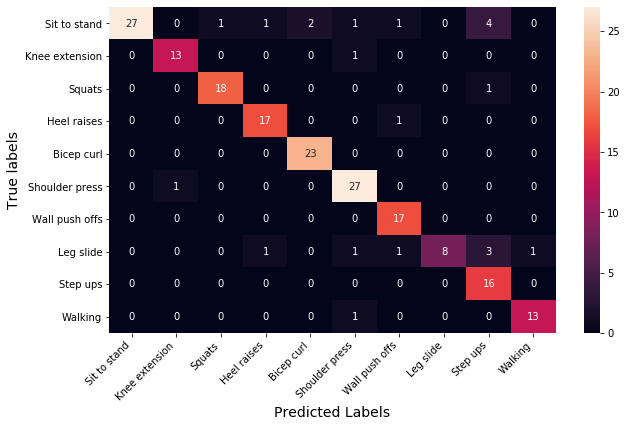

In [79]:
# plot cm
y_pred_ohe = model_norm.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

activity_labels = get_activity_label_dict()
cm_labels = [activity_labels[i] for i in range(10)]

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
plt.xlabel("Predicted Labels", fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.ylabel("True labels", fontsize=14)

plt.savefig("../Plots/05_Universal_classifier/baseline_norm_model_cm.pdf")

In [75]:
final_loss, final_acc, final_mse = model_norm.evaluate(X_test, y_test, batch_size)
print("Final loss = {}".format(final_loss))
print("Final accuracy = {}".format(final_acc))

201/201 [==============================] - 0s 589us/step
Final loss = 0.45701181106454697
Final accuracy = 0.8905472755432129


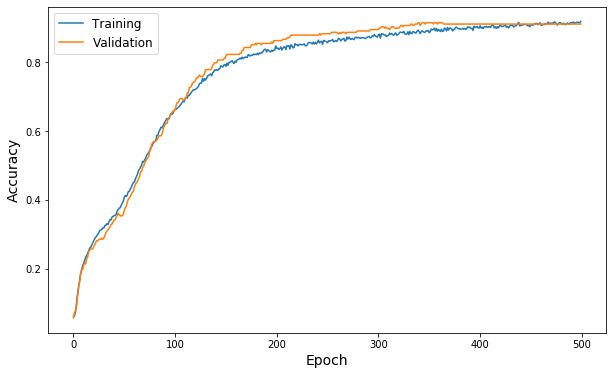

In [80]:
fig = plt.figure(figsize=(10,6))
plt.plot(history_norm.history['accuracy'], label='Training')
plt.plot(history_norm.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.savefig("../Plots/05_Universal_classifier/baseline_norm_model_learning_curve.pdf")

Quick export to android, is this really working?

In [82]:
model_norm.save("universal_model.h5", include_optimizer=False)

In [85]:
history_norm.history['loss'][-1]

0.3213318061063634

### Plot accuracies

In [4]:
results = pd.read_csv("../Plots/06_LOSOXV/baseline_stats_losoxv.csv")

In [8]:
print("Training avg accuracy - {}".format(results['train_acc'].mean()))
print("Validation avg accuracy - {}".format(results['valid_acc'].mean()))
print("Test avg accuracy - {}".format(results['test_acc'].mean()))

Training avg accuracy - 0.9168446113333332
Validation avg accuracy - 0.8756981929143269
Test avg accuracy - 0.8875036994616191


In [ ]:
results['valid_acc'].mean()